**This is my second Kernel on Titanic Survival Challenge. The purpose of this kernel is to try feature engineering and see if it can improve the score. Also, I have been reading different kernels on this problem so, I though it is good to put some of the best practices people are using in their kernels.** 

***In Short, learning by doing!!***

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train.csv', 'gender_submission.csv', 'test.csv']


In [2]:
#import libraries

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#We will use different classifiers and then try Voting Classifier to see if it helps in increasing score.

#Classfiers used in _v1
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

#Ensemble
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier

#Model_selection

from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

#set data visualization stying

sns.set(style='white', context = 'notebook', palette='deep')

In [3]:
#Load data

train_data = pd.read_csv('../input/train.csv')
test_data = pd.read_csv('../input/test.csv')
IDtest = test_data["PassengerId"]

While doing an online course, that we should remove outliers, if possible, from the data. The method they used was find 1st and 3rd quartiles and get **interquartile ranges** (IQR), $Q3-Q1$ and see if there are data points which are beyond $1.5*IQR$ on both sides. 

Then if any row which has more than 2 or more outlier columns, can be removed from training data.

In [4]:
#Outlier Detection

from collections import Counter

def get_outliers(df,n,features):
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        #1st Quartile
        Q1 = np.percentile(df[col],25)
        #3rd Quartile
        Q3 = np.percentile(df[col],75)
        #Inter-Quartile Range
        IQR = Q3 - Q1
        
        #Outliers Range        
        outliers_boundary = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        list_outlier_cols = df[(df[col] < Q1 - outliers_boundary) | (df[col] > Q3 + outliers_boundary)].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(list_outlier_cols)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    more_than_two_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return more_than_two_outliers   

#Function takes 3 parameters - DataFrame,number of outliers you want to check in an observations, feature columns 
Outliers_to_drop = get_outliers(train_data, 2, ["Age","SibSp","Parch","Fare"])
        

/opt/conda/lib/python3.6/site-packages/numpy/lib/function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


In [5]:
train_data.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [6]:
#Drop outliers

train_data = train_data.drop(Outliers_to_drop, axis = 0)

Out of 10 outliers, 3 have very high ticket fares as compared to other, and 7 have high value of SibSp

In this Titanic_v2, I will combine the test and training data and then we will do all the operations on both the data set. This can be done by creating data_processing function and then call over two data sets insdividually as well, which was the idea in Titanic_v1 ( although we didn't create a function then and ran the steps individaully twice. 

In [7]:
#Concate datasets
full_dataset = pd.concat(objs=[train_data,test_data], axis = 0).reset_index(drop=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [8]:
full_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1299 entries, 0 to 1298
Data columns (total 12 columns):
Age            1043 non-null float64
Cabin          292 non-null object
Embarked       1297 non-null object
Fare           1298 non-null float64
Name           1299 non-null object
Parch          1299 non-null int64
PassengerId    1299 non-null int64
Pclass         1299 non-null int64
Sex            1299 non-null object
SibSp          1299 non-null int64
Survived       881 non-null float64
Ticket         1299 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 121.9+ KB


In [9]:
full_dataset.isnull().sum()

Age             256
Cabin          1007
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

Survived has 418 NaN because the dataset is a combination of test and train data and test data doesn't contain Survived columns.

## Feature Engineering


We will analyse train data set features but whatever operation we will be doing on data, it will be on combined dataset (final_dataset)

In [10]:
#In Version V1, we didn't look into SibSp and Parch features, so let's start with them.

train_data[['SibSp', 'Survived']].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
4,4,0.166667
3,3,0.153846
5,5,0.000000


Interesting, passengers with less numbers of siblings tends to survive more. For example 0, 1 and 2 sibling passengers have 34%, 46% and 53% survival rate. 

This can be included in our new features.

In [11]:
#Let's do the similar analysis for Parch

train_data[['Parch', 'Survived']].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.542857
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


Again, small families have more chnaces to survive 3 being highest.

In [12]:
#As we can see large family have less survival rate, I am going to make a new feature which we can call family size.
#Family size = SibSp + Parch + Individual

full_dataset["FamilySize"] = full_dataset["SibSp"] + full_dataset["Parch"] + 1


In [13]:
full_dataset.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,FamilySize
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,2
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,2
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,1
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,2
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,1


In [14]:
#Also I am going to drop Cabin Variable as Cabin has more than 70% null

full_dataset.drop(["Cabin"],axis =1, inplace=True)

In [15]:
full_dataset.head()

,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,FamilySize
0,22.0,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,2
1,38.0,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,2
2,26.0,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,1
3,35.0,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,2
4,35.0,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,1


Last time we imputed age with median age of the population, but this time we are going to do something extra. I will find the correlation of age with different features and see if age can be imputed on the sub-population level.



# Fill missing Values

In [16]:
#Embarked - Since only two values are missing and that is in training data, we can fill it with highest occuring value as we did in V1.
full_dataset["Embarked"].fillna('S', inplace=True)

In [17]:
#Fare can be filled with median value as well.

fare_median = full_dataset["Fare"].median()
fare_median

full_dataset["Fare"].fillna(fare_median, inplace=True)

In [18]:
#Let's do one hot encoding like V1.

from sklearn.preprocessing import LabelEncoder

le_pClass = LabelEncoder()
le_sex = LabelEncoder()
le_embarked = LabelEncoder()
full_dataset['PClass_encoded'] = le_pClass.fit_transform(full_dataset.Pclass)
full_dataset['Sex_encoded'] = le_sex.fit_transform(full_dataset.Sex)
full_dataset['Embarked_encoded'] = le_embarked.fit_transform(full_dataset.Embarked)

In [19]:
full_dataset.head()

,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,FamilySize,PClass_encoded,Sex_encoded,Embarked_encoded
0,22.0,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,2,2,1,2
1,38.0,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,2,0,0,0
2,26.0,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,1,2,0,2
3,35.0,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,2,0,0,2
4,35.0,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,1,2,1,2


In [20]:
#One hot encoding for categorical columns (PClass, Sex, Embarked)

from sklearn.preprocessing import OneHotEncoder

pClass_ohe = OneHotEncoder()
sex_ohe = OneHotEncoder()
embarked_ohe = OneHotEncoder()

Xp =pClass_ohe.fit_transform(full_dataset.PClass_encoded.values.reshape(-1,1)).toarray()
Xs =sex_ohe.fit_transform(full_dataset.Sex_encoded.values.reshape(-1,1)).toarray()
Xe =embarked_ohe.fit_transform(full_dataset.Embarked_encoded.values.reshape(-1,1)).toarray()

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a Lab

In [21]:
#Add back to original dataframe

train_dataOneHot = pd.DataFrame(Xp, columns = ["PClass_"+str(int(i)) for i in range(Xp.shape[1])])
full_dataset = pd.concat([full_dataset, train_dataOneHot], axis=1)

train_dataOneHot = pd.DataFrame(Xs, columns = ["Sex_"+str(int(i)) for i in range(Xs.shape[1])])
full_dataset = pd.concat([full_dataset, train_dataOneHot], axis=1)

train_dataOneHot = pd.DataFrame(Xe, columns = ["Embarked_"+str(int(i)) for i in range(Xe.shape[1])])
full_dataset = pd.concat([full_dataset, train_dataOneHot], axis=1)

In [22]:
full_dataset.head()

,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,FamilySize,PClass_encoded,Sex_encoded,Embarked_encoded,PClass_0,PClass_1,PClass_2,Sex_0,Sex_1,Embarked_0,Embarked_1,Embarked_2
0,22.0,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,2,2,1,2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
1,38.0,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,2,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,26.0,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,1,2,0,2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,35.0,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,2,0,0,2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,35.0,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,1,2,1,2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


Last time we didn't do anything with two features, Name and Ticket. Also, we imputed Age with median. let's see if we can do something more this time.

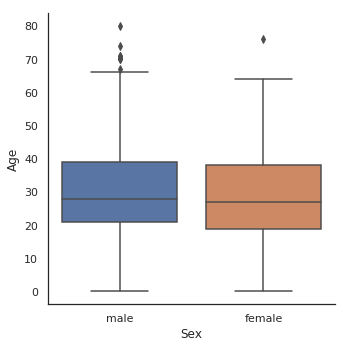

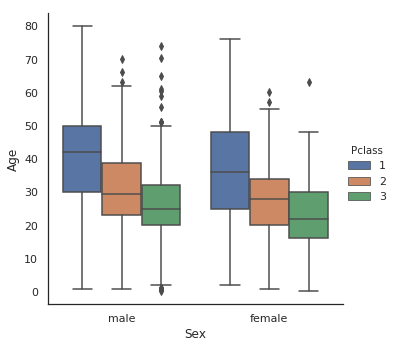

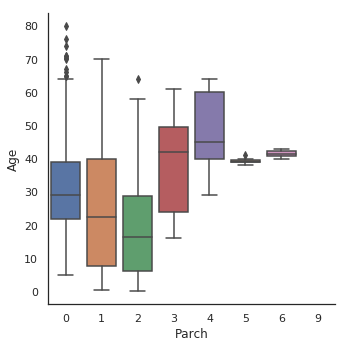

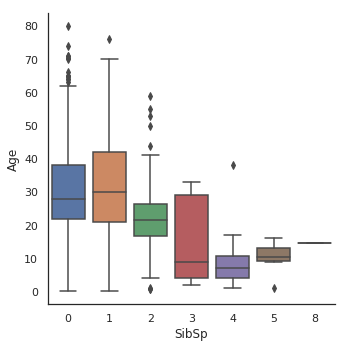

In [23]:
#First, let us take age.
#Let us see how other features are correlated with age and if we can impute age as per other features.

g = sns.catplot(y="Age",x="Sex",data=full_dataset,kind="box")
g = sns.catplot(y="Age",x="Sex",hue="Pclass", data=full_dataset,kind="box")
g = sns.catplot(y="Age",x="Parch", data=full_dataset,kind="box")
g = sns.catplot(y="Age",x="SibSp", data=full_dataset,kind="box")

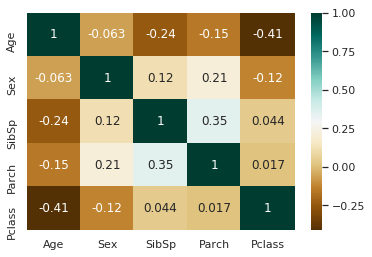

In [24]:
#Convert Sex feature into 0 and 1 and then check correlation matrix.

full_dataset["Sex"] = full_dataset["Sex"].map({"male": 0, "female":1})

g = sns.heatmap(full_dataset[["Age","Sex","SibSp","Parch","Pclass"]].corr(),cmap="BrBG",annot=True)

Factorplot and correlation matrix tells us that while age is not related to Sex of the passenger but it is negatively correlated to SibSp, Parch and PClass, so we can impute the age of the passenger, where it is not present , with the median of age of similar rows of PClass, SibSp, and Parch.

In [25]:
#Get indexes of rows with NaN as age.
#We are getting indexes of all the columns and then getting back all the indexes where Age is null

index_NaN_age = list(full_dataset["Age"][full_dataset["Age"].isnull()].index)


for i in index_NaN_age:
    age_med = full_dataset["Age"].median()
    age_pred = full_dataset["Age"][((full_dataset['SibSp'] == full_dataset.iloc[i]["SibSp"]) 
                                    & (full_dataset['Parch'] == full_dataset.iloc[i]["Parch"]) 
                                    & (full_dataset['Pclass'] == full_dataset.iloc[i]["Pclass"]))].median()
    if not np.isnan(age_pred) :
        full_dataset['Age'].iloc[i] = age_pred
    else :
        full_dataset['Age'].iloc[i] = age_med

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


We have no Nan in our dataset now, but we have not done feature engineering on Ticket and Name feature yet. Can we do something there?

In [26]:
#Name, Get title from the name.

full_dataset_title = [i.split(",")[1].split(".")[0].strip() for i in full_dataset["Name"]]
full_dataset["Title"] = pd.Series(full_dataset_title)
full_dataset["Title"].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

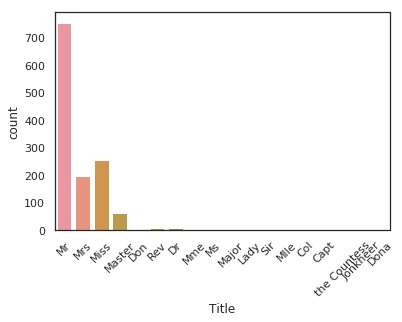

In [27]:
#Histogram for Titles

g = sns.countplot(x="Title", data = full_dataset)
g = plt.setp(g.get_xticklabels(), rotation = 45)

There are mainly 4 titles and all other titles are very rare. We will make 4 titles, Mr, Mrs/Miss, Master, Others

In [28]:

#Replace with Rare
full_dataset["Title"] = full_dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 
                                             'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
#Replace feminine titles with Ms.
full_dataset["Title"] = full_dataset["Title"].replace(['Miss', 'Ms','Mme','Mlle', 'Mrs'], 'Ms')

#Map titles
full_dataset["Title"] = full_dataset["Title"].map({"Master":0, "Ms":1 ,"Mr":2, "Rare":3})
full_dataset["Title"] = full_dataset["Title"].astype(int)


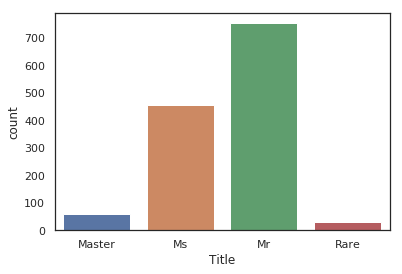

In [29]:
#Histogram Again
g = sns.countplot(x="Title", data = full_dataset)
g = g.set_xticklabels(["Master","Ms","Mr","Rare"])

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


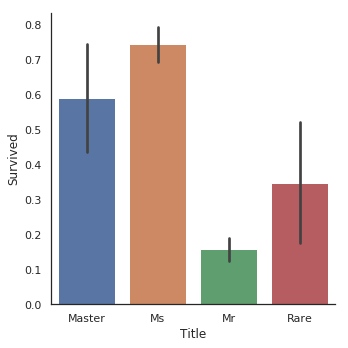

In [30]:
#Let us see if survival chnaces depends on titles.

g = sns.catplot(x="Title", y= "Survived", data = full_dataset, kind ='bar')
g = g.set_xticklabels(["Master","Ms","Mr","Rare"])

Clearly women and childrens have higher rate of survivals.

In [31]:
#We can now remove Name column

full_dataset.drop(["Name"], axis=1, inplace=True)

I am going to work on Ticket, Cabin and FamilySize in the next iteration.

In [32]:
full_dataset.head()

,Age,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,FamilySize,PClass_encoded,Sex_encoded,Embarked_encoded,PClass_0,PClass_1,PClass_2,Sex_0,Sex_1,Embarked_0,Embarked_1,Embarked_2,Title
0,22.0,S,7.2500,0,1,3,0,1,0.0,A/5 21171,2,2,1,2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,2
1,38.0,C,71.2833,0,2,1,1,1,1.0,PC 17599,2,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1
2,26.0,S,7.9250,0,3,3,1,0,1.0,STON/O2. 3101282,1,2,0,2,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1
3,35.0,S,53.1000,0,4,1,1,1,1.0,113803,2,0,0,2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1
4,35.0,S,8.0500,0,5,3,0,0,0.0,373450,1,2,1,2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,2


# Modeling

In [33]:
#Drop extra columns

full_dataset.drop(["PassengerId","Embarked","Pclass","Sex", "Ticket","Parch", "SibSp", 
                   "PClass_encoded","Sex_encoded","Embarked_encoded"]
                , axis =1, inplace=True)

full_dataset.head()

,Age,Fare,Survived,FamilySize,PClass_0,PClass_1,PClass_2,Sex_0,Sex_1,Embarked_0,Embarked_1,Embarked_2,Title
0,22.0,7.2500,0.0,2,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,2
1,38.0,71.2833,1.0,2,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1
2,26.0,7.9250,1.0,1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1
3,35.0,53.1000,1.0,2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1
4,35.0,8.0500,0.0,1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,2


In [34]:
train_len = len(train_data)
train_len

881

In [35]:
#Let's divide data into Train and test now.

train_data = full_dataset[:train_len]
test_data = full_dataset[train_len:]

#drop survived column from test_data

test_data.drop(["Survived"], axis =1, inplace=True)

print(train_data.shape)
print(test_data.shape)
      

(881, 13)
(418, 12)


/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [36]:
#Separating features and target variable from training data

train_data["Survived"] = train_data["Survived"].astype(int)
train_data["Fare"] = train_data["Fare"].astype(float)


y_train = train_data["Survived"]
X_train = train_data.drop(labels=["Survived"], axis =1)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In this version 2 I will be using:

* SVC
* RandomForest
* AdaBoost
* Decision Tree
* Extra Trees
* Gradient Boosting
* KNN
* Logistic Regression




In [37]:
#10 fold cross validation

kfold = StratifiedKFold(n_splits=10)

In [38]:
#Modeling Steps.

random_state = 42
classifiers = []
classifiers.append(SVC(random_state = random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),
                                      random_state=random_state,learning_rate =0.1))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state=random_state))



cv_results = []

for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, X_train, y_train, scoring="accuracy", cv = kfold, n_jobs=-1))
    
cv_means = []
cv_std = []

for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
    
cv_res = pd.DataFrame({"CrossValMeans": cv_means, "CrossValErrors": cv_std, 
                       "Algorithm": ["SVC", "RandomForestClassifier", "AdaBoostClassifier",
                                     "Decision Tree Classifier", "Extra Trees" ,"Gradient Boosting", 
                                     "K Nearest Neighbors", "Logistic regression"]})

cv_res = cv_res.sort_values(by = "CrossValMeans", ascending=False)
cv_res

,CrossValMeans,CrossValErrors,Algorithm
5,0.844510,0.045410,Gradient Boosting
7,0.820672,0.031157,Logistic regression
1,0.805937,0.034774,RandomForestClassifier
4,0.792326,0.050607,Extra Trees
2,0.791203,0.048223,AdaBoostClassifier
3,0.785470,0.045864,Decision Tree Classifier
0,0.741228,0.044657,SVC
6,0.734410,0.028652,K Nearest Neighbors


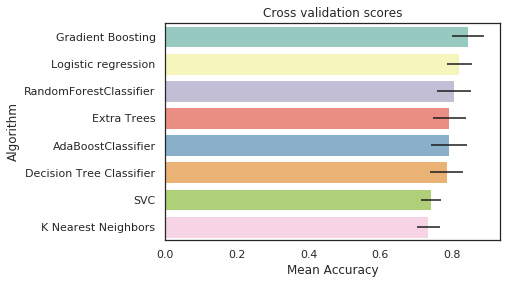

In [39]:
g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

In [40]:
#Predictions on test data
gbc_clf = GradientBoostingClassifier(random_state=random_state)
gbc_clf.fit(X_train, y_train)


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=42,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [41]:
Y_pred = gbc_clf.predict(test_data)

In [42]:
submission = pd.DataFrame({
        "PassengerId": IDtest,
        "Survived": Y_pred
    })

submission.to_csv('Titanic_Prediction_v2.csv', index=False)

# To do in next Version

*  More feature engineering
*  Hyper parameter Tuning
*  Ensemble Modeling
*  Learning Curve Graphs